# Imports:

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import h5py
import time
import torch
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from braindecode.models.deep4 import Deep4Net
from braindecode.models import EEGNetv4
import braindecode
import torch.nn.functional as F
from scipy import signal
import scipy

In [2]:
!pwd
# projects/def-b09sdp/bijan/Phase2/P16.fdt

/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI


In [3]:
print(braindecode.__version__)

0.7


# Functions:

Mode: 'binary', '3-class', '4-class', '5-class', '6-class'

In [4]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [5]:
def encoder(y_data, method=OneHotEncoder):

    for i in range(len(y_data)):
        encoder = OneHotEncoder()
        a = encoder.fit_transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [6]:
class EEG_Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label


In [7]:
def Epoch_slicer(data_epochs, data_labels, epoch_length=100, overlap=0.5):
    

    original_epoch = data_epochs[0].shape[-1]


    EEG_epochs_aug = []
    EEG_labels_aug = []

    overlap_samples = (1-overlap) * epoch_length
    for i in range(len(EEG_epochs)):
        person_epoch = []
        person_label = []
    
    
    
        for j in range(data_epochs[i].shape[0]):
        
            upper_lim = epoch_length
            lower_lim = 0
        
            while upper_lim < original_epoch:
                person_epoch.append(data_epochs[i][j][:, lower_lim:upper_lim])
                person_label.append(data_labels[i][j])
                lower_lim, upper_lim = int(lower_lim + overlap_samples), int(upper_lim + overlap_samples)
        EEG_epochs_aug.append(np.array(person_epoch))
        EEG_labels_aug.append(np.array(person_label))
    
    
    return EEG_epochs_aug, EEG_labels_aug

# Device (GPU\CPU\MPS)

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Model

In [32]:
model = EEGNetv4(in_chans=64, n_classes=6, input_window_samples=100)


X_torch = torch.randn(size=(50, 64, 100))  # size: (batch, in_chans, input_window_samples)
y_torch = torch.randint(low=0, high=6, size=(50,))  # size: (batch), values: 0 or 1

summary(model, (64, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Ensure4d-1           [-1, 64, 100, 1]               0
        Expression-2           [-1, 1, 64, 100]               0
            Conv2d-3           [-1, 8, 64, 101]             512
       BatchNorm2d-4           [-1, 8, 64, 101]              16
Conv2dWithConstraint-5           [-1, 16, 1, 101]           1,024
       BatchNorm2d-6           [-1, 16, 1, 101]              32
        Expression-7           [-1, 16, 1, 101]               0
         AvgPool2d-8            [-1, 16, 1, 25]               0
           Dropout-9            [-1, 16, 1, 25]               0
           Conv2d-10            [-1, 16, 1, 26]             256
           Conv2d-11            [-1, 16, 1, 26]             256
      BatchNorm2d-12            [-1, 16, 1, 26]              32
       Expression-13            [-1, 16, 1, 26]               0
        AvgPool2d-14             [-1,

In [26]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 16 * 25, 128)  # Calculate the correct input size based on image dimensions
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), 1, 64, 100)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the tensor before the fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Example usage
num_classes = 6  # Number of classes for your classification task
#model = CNNModel(num_classes)
#torchsummary.summary(model, (1, 64, 100))

EEGNet
![image.png](attachment:ba9698db-121b-4f7f-bddc-79af1023b21e.png )
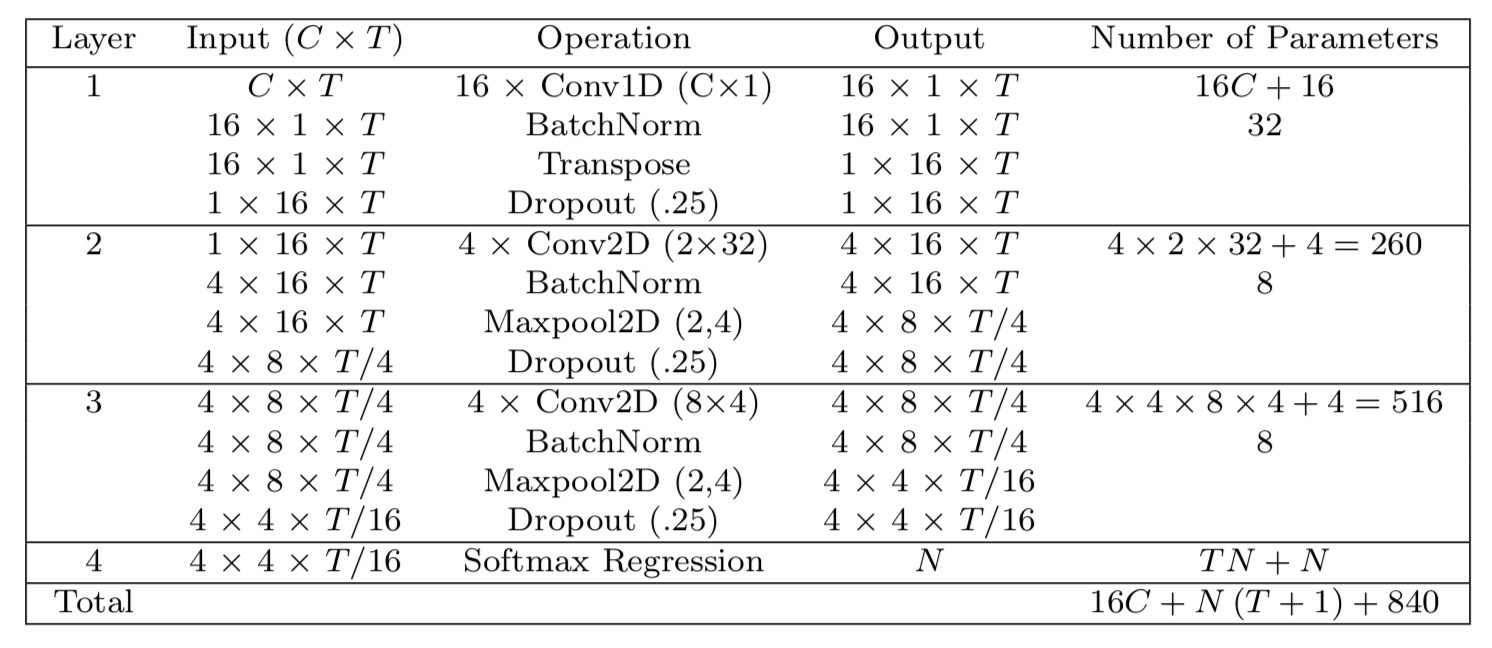

In [45]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4) # 2 is for kernel, 4 is for stride
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4)) # Kernel is of size (2, 4)
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*2*6, 6)
        

    def forward(self, x):
        # Initial Permutation because of model and input inconsistency 
        x = x.permute(0, 1, 3, 2)
        
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.reshape(-1, 4*2*6)
        x = F.softmax(self.fc1(x), dim=0)
        return x


In [46]:
# Assuming EEGNet is defined somewhere in your code
model = EEGNet()

# Specify the input shape (1 channel, 120 time steps, 64 features)
input_shape = (1, 64, 100)

# Print the summary of the model
print(summary(model, input_shape, device="cpu"))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 100, 1]           1,040
       BatchNorm2d-2           [-1, 16, 100, 1]              32
         ZeroPad2d-3           [-1, 1, 17, 133]               0
            Conv2d-4           [-1, 4, 16, 102]             260
       BatchNorm2d-5           [-1, 4, 16, 102]               8
         MaxPool2d-6             [-1, 4, 4, 26]               0
         ZeroPad2d-7            [-1, 4, 11, 29]               0
            Conv2d-8             [-1, 4, 4, 26]             516
       BatchNorm2d-9             [-1, 4, 4, 26]               8
        MaxPool2d-10              [-1, 4, 2, 6]               0
           Linear-11                    [-1, 6]             294
Total params: 2,158
Trainable params: 2,158
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/back

Shallow Network Introduced in EEGNet Paper:


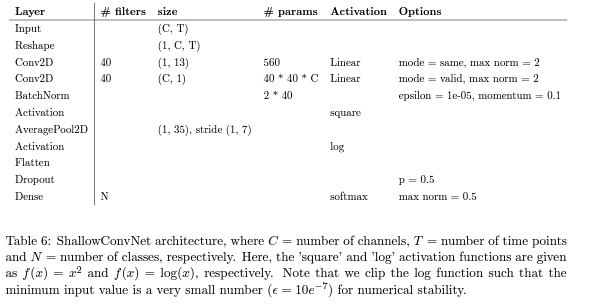

In [ ]:
inp = torch.tensor(np.random.rand(10, 64, 100), dtype=torch.float32)
model(inp)


# Pre-trained Model

In [37]:
def Modified_Model():
    
    pretrained_model = Deep4Net(
    in_chans=62,
    n_classes=2,
    input_window_samples=1000,
    final_conv_length='auto'
    )


    state_dict = torch.load('model_f1.pt', map_location=torch.device('cpu'))

    #print(state_dict['model_state_dict'])


    # for key, value in state_dict.items():
    #     print(key, value)

    pretrained_model.load_state_dict(state_dict['model_state_dict'])

    #print(pretrained_model)

    for i, (name, param) in enumerate(pretrained_model.named_parameters()):
        if i <= 1:
            param.requires_grad = False
        else:
            param.requires_grad = True 
        



    class My_model(nn.Module):
        def __init__(self, in_features, num_classes):
            super(My_model, self).__init__()
            self.Conv2d_1 = nn.Conv2d(in_features, 300, kernel_size=(7, 1), stride=(1, 1))
            self.Conv2d_2 = nn.Conv2d(300, num_classes, kernel_size=(1, 1), stride=(1, 1))
        def forward(self, x):
            x = self.Conv2d_1(x)
            x = self.Conv2d_2(x)
            x = x.view(x.size(0), -1)
        
            return x
    # Clone layers up to the last layer before the classifier
    pretrained_layers = nn.Sequential(
    pretrained_model.ensuredims,
    pretrained_model.dimshuffle,
    pretrained_model.conv_time,
    pretrained_model.conv_spat,
    pretrained_model.bnorm,
    pretrained_model.conv_nonlin,
    pretrained_model.pool,
    pretrained_model.pool_nonlin,
    pretrained_model.drop_2,
    pretrained_model.conv_2,
    pretrained_model.bnorm_2,
    pretrained_model.nonlin_2,
    pretrained_model.pool_2,
    pretrained_model.pool_nonlin_2,
    pretrained_model.drop_3,
    pretrained_model.conv_3,
    pretrained_model.bnorm_3,
    pretrained_model.nonlin_3,
    pretrained_model.pool_3,
    pretrained_model.pool_nonlin_3,
    pretrained_model.drop_4,
    pretrained_model.conv_4,
    pretrained_model.bnorm_4,
    pretrained_model.nonlin_4,
    pretrained_model.pool_4,
    pretrained_model.pool_nonlin_4
    )


    # Create and set your custom classifier
    custom_classifier = My_model(in_features=200, num_classes=6)


    # Setting the last layer to be trainable
    for param in custom_classifier.parameters():
        param.requires_grad = True

    
    # Combine the cloned layers and custom classifier
    new_model = nn.Sequential(pretrained_layers, custom_classifier)

    return new_model

In [11]:
# Just checking if the model is loaded properly !!!

# state = new_model.state_dict()
# for name, child in state.items():
#     print(name, child)

In [34]:
new_model = Modified_Model()

Deep4Net(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=transpose_time_to_spat) 
  (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
  (conv_spat): Conv2d(25, 25, kernel_size=(1, 62), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=elu) 
  (pool): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (pool_nonlin): Expression(expression=identity) 
  (drop_2): Dropout(p=0.5, inplace=False)
  (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), bias=False)
  (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin_2): Expression(expression=elu) 
  (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (pool_nonlin_2): Expression(expression=identity) 
  (drop_3): Dropout(p=0.5, inplace=False)
  (conv_3): Conv2d(50, 100, kerne

In [35]:
# Checking each layer is trainable or not :)

for name, param in new_model.named_parameters():
    if param.requires_grad:
        print("The layer {} is trainable.".format(name))
        
    else:
        print("The layer {} is not trainable!!!".format(name))

The layer 0.2.weight is not trainable!!!
The layer 0.2.bias is not trainable!!!
The layer 0.3.weight is trainable.
The layer 0.4.weight is trainable.
The layer 0.4.bias is trainable.
The layer 0.9.weight is trainable.
The layer 0.10.weight is trainable.
The layer 0.10.bias is trainable.
The layer 0.15.weight is trainable.
The layer 0.16.weight is trainable.
The layer 0.16.bias is trainable.
The layer 0.21.weight is trainable.
The layer 0.22.weight is trainable.
The layer 0.22.bias is trainable.
The layer 1.Conv2d_1.weight is trainable.
The layer 1.Conv2d_1.bias is trainable.
The layer 1.Conv2d_2.weight is trainable.
The layer 1.Conv2d_2.bias is trainable.


# Data reading:

\
\
Read all the data except participant 1 (P2 - P15)

In [9]:
if device == 'cuda':
    print("Running on cloud ...")
    print("Please make sure to modify how you read the data according to your need!\n\n")
    raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase2/"
    data_epochs = []
    data_labels = []

    for participant_id in range(16, 31):
        if participant_id == 17 or participant_id == 24:
            continue
        participant = f"P{participant_id}"
        file_path = f"{raw_data_path}/{participant}.set"
        epochs = mne.io.read_epochs_eeglab(file_path)
        data_epochs.append(epochs.get_data())
        data_labels.append(epochs.events[:, -1])

elif device == 'cpu':
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:/Hadi_BCI/Recordings/Phase 2/PreProcessedData"
    data_epochs = []
    data_labels = []
    for participant_id in range(16, 31):
        if participant_id == 17 or participant_id == 24:
            continue
        participant = f"P{participant_id}/P{participant_id}"
        file_path = f"{raw_data_path}/{participant}.set"
        epochs = mne.io.read_epochs_eeglab(file_path)
        data_epochs.append(epochs.get_data())
        data_labels.append(epochs.events[:, -1])

Running on cloud ...
Please make sure to modify how you read the data according to your need!


Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P16.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P18.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P19.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P20.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P21.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P22.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P23.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
479 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P25.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P26.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
479 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P27.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P28.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P29.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P30.set...


/tmp/ipykernel_238226/792226638.py:13: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [10]:
print("The epochs data shape for participant 1:    ", data_epochs[0].shape)
print("The labels shape for participant 1:         ", data_labels[0].shape)

The epochs data shape for participant 1:     (480, 64, 1123)
The labels shape for participant 1:          (480,)


In [11]:
data_labels[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,

In [12]:
data_epochs[0].shape

(480, 64, 1123)

In [13]:
epoch = mne.io.read_epochs_eeglab(file_path)

Extracting parameters from /home/bijan/projects/def-b09sdp/bijan/Phase2/P30.set...
Not setting metadata
480 matching events found


/tmp/ipykernel_238226/3691134859.py:1: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  epoch = mne.io.read_epochs_eeglab(file_path)


No baseline correction applied
0 projection items activated
Ready.


In [14]:
epoch.event_id

{'Rest': 1,
 'Right': 2,
 'Left': 3,
 'Feet': 4,
 'Si': 5,
 'Rs': 6,
 'Ls': 7,
 'Fs': 8}

In [15]:
sos = signal.butter(8, [0.5, 32.5], 'bp', fs=250, output='sos')
A = np.linspace(0, 2, 500)
B = 10 * np.sin(2*np.pi*0.1*A)  + 2*np.cos(2*np.pi*10*A)

C = signal.sosfilt(sos, B)



# Left / Singing / Left-Singing / Rest

In [13]:
EEG_epochs, labels = data_wrapper(data_epochs, data_labels, mode='4_class_LS')

# Right / Singing / Right-Singing / Rest

In [ ]:
EEG_epochs, labels = data_wrapper(data_epochs, data_labels, mode='4_class_RS')

# L / LS / S / RS / R / Rest (6-Class)

In [15]:
EEG_epochs, labels = data_wrapper(data_epochs, data_labels, mode='6_class')

# The encoding process + Cropping signals for TL model:

In [17]:
EEG_epochs[0].shape

(360, 64, 1123)

In [18]:
labels[0].shape

(360,)

# Data Augumentation

In [16]:
EEG_epochs_aug, EEG_labels_aug = Epoch_slicer(EEG_epochs, labels, epoch_length=100, overlap=0.3)

In [17]:
print("The epochs data shape for participant 1:    ", EEG_epochs_aug[0].shape)
print("The labels shape for participant 1:         ", EEG_labels_aug[0].shape)

The epochs data shape for participant 1:     (5400, 64, 100)
The labels shape for participant 1:          (5400,)


In [18]:
no_encode = copy.deepcopy(EEG_labels_aug)
encoded = encoder(EEG_labels_aug)

In [19]:
print("Epochs Length:", len(EEG_epochs_aug))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", EEG_epochs_aug[0].shape)
print("Participant 16 - labels[0] shape:", encoded[0].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(EEG_labels_aug[0])

Epochs Length: 13
labels Length: 13



Participant 16 - Epochs[0] shape: (5400, 64, 100)
Participant 16 - labels[0] shape: (5400, 6)



Participant 16 - labels[0]:
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [20]:
encoded[0][[1, 10, 20, 30, 40, 50, 60]]

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [21]:
len(no_encode)

13

# Checking the criterion:

# Within Subject:

In [29]:
participants = [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0001
weight_decay=0.25*learning_rate

confusion_matrices = []


for i in range(len(EEG_epochs)):

    epoch_participant = EEG_epochs[i]
    encoded_participant = encoded[i]
    
    split_index = 40 # The last n = split_index samples are in the test set
    
    train_epoch, test_epoch = epoch_participant[:-1*split_index], epoch_participant[-1*split_index:]
    train_label, test_labels = encoded_participant[:-1*split_index], encoded_participant[-1*split_index:]
    no_encode_train_label = no_encode[i][:-1*split_index]
    no_encode_test_label = no_encode[i][-1*split_index:]
    
    # print(train_epoch.shape)
    # print(train_label.shape)
    # print(len(no_encode_train_label))
    
    batch_size = 12  # Set your batch size
    fold_num = int(EEG_epochs[i].shape[0] // batch_size)
    

    
    #model = Deep4Net(in_chans=64, n_classes=4, input_window_samples=1123, final_conv_length='auto')
    
    model = new_model
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    model.to(device)
    model.train()
    
    patience = 300
    best_metric = float('inf')
    counter = 1
    best_model_state = model.state_dict()
    
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    
    
    
    models = []
    
    
    for epoch in range(max_epochs):
        
        temp_train_pred = []
        temp_train_true = []
        
        train_running_loss = 0
        
        stratified_kfold = StratifiedKFold(n_splits=fold_num, random_state=1, shuffle=True)
        
        for _, (_, train_batch_index) in enumerate(stratified_kfold.split(train_epoch, no_encode_train_label)):
            
            batch_epoch, batch_label = train_epoch[train_batch_index], train_label[train_batch_index]
            
            train_dataset = EEG_Dataset(batch_epoch, batch_label, transform=None)
            train_loader = DataLoader(train_dataset, batch_size=batch_epoch.shape[0])
        
        
            for train_inputs, train_labels in train_loader:
                #print(train_labels)
                train_inputs, train_labels = train_inputs.to(torch.float32).to(device), train_labels.to(torch.float32).to(device)
            
                optimizer.zero_grad()
                train_outputs = model(train_inputs)
                loss = criterion(train_outputs, train_labels)
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item()
                y_pred_train = torch.argmax(train_outputs, 1).tolist()
                y_true_train = torch.argmax(train_labels, 1).tolist()
                temp_train_pred.extend(y_pred_train)
                temp_train_true.extend(y_true_train)
                
        test_dataset = EEG_Dataset(test_epoch, test_labels, transform=None)
        test_loader = DataLoader(test_dataset, batch_size=test_epoch.shape[0])
            
        with torch.no_grad():
            for test_input, test_label in test_loader:
                
                test_input, test_label = test_input.to(torch.float32).to(device), test_label.to(torch.float32).to(device)
                test_output = model(test_input)
                test_loss = criterion(test_output, test_label).item()
                y_pred_test = torch.argmax(test_output, 1).tolist()
                y_true_test = torch.argmax(test_label, 1).tolist()
                test_conf_mat = confusion_matrix(y_true_test, y_pred_test)
                test_accuracy = np.trace(test_conf_mat) / test_conf_mat.sum()
        
        avg_train_loss = train_running_loss / fold_num
        
        train_loss_epochs.append(avg_train_loss)
        test_loss_epochs.append(test_loss)
        test_acc_epochs.append(test_accuracy)
        train_conf_mat = confusion_matrix(temp_train_true, temp_train_pred)
        train_accuracy = np.trace(train_conf_mat) / train_conf_mat.sum()
        train_acc_epochs.append(train_accuracy)
        
        if epoch % 5 == 0:
            print(f"Epoch [{(epoch + 1): 3d}/{max_epochs}] - Avg Training Loss: {avg_train_loss:.4f} Train Accuracy: {train_accuracy:.2f} - Test Loss: {test_loss:.2f} - Test Accuracy: {test_accuracy:.2f}")
        
        if test_loss < best_metric:
            best_metric = test_loss
            best_model_state = model.state_dict()
            counter = 1
        
        else:
            counter += 1
        
        if counter > patience:
            break
        best_epoch = epoch-patience+2
        epochs_range = np.arange(1, len(train_loss_epochs[:best_epoch])+1)
        
        
    model.load_state_dict(best_model_state)
    
    
                
    test_input, test_labels = torch.tensor(test_epoch, dtype=torch.float32).to(device), torch.tensor(test_labels, dtype=torch.float32).to(device)
    test_output = model(test_input)
    y_pred_test = torch.argmax(test_output, 1).tolist()
    y_true_test = torch.argmax(test_labels, 1).tolist()
    all_tests_true.append(y_true_test)
    all_tests_pred.append(y_pred_test)
        
    
    
    models.append(best_model_state)
    
    
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[i]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:best_epoch])
    plt.plot(epochs_range, test_loss_epochs[:best_epoch])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:best_epoch])
    plt.plot(epochs_range, test_acc_epochs[:best_epoch])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}_within_subject.jpg".format(participants[i]))
    plt.show()
    plt.clf()

Epoch [  1/500] - Avg Training Loss: 1.7928 Train Accuracy: 0.16 - Test Loss: 1.80 - Test Accuracy: 0.28
Epoch [  6/500] - Avg Training Loss: 1.7879 Train Accuracy: 0.17 - Test Loss: 1.84 - Test Accuracy: 0.00
Epoch [ 11/500] - Avg Training Loss: 1.7936 Train Accuracy: 0.18 - Test Loss: 1.85 - Test Accuracy: 0.00
Epoch [ 16/500] - Avg Training Loss: 1.7871 Train Accuracy: 0.18 - Test Loss: 1.86 - Test Accuracy: 0.00
Epoch [ 21/500] - Avg Training Loss: 1.7876 Train Accuracy: 0.21 - Test Loss: 1.84 - Test Accuracy: 0.00
Epoch [ 26/500] - Avg Training Loss: 1.7900 Train Accuracy: 0.18 - Test Loss: 1.85 - Test Accuracy: 0.00


KeyboardInterrupt: 

In [29]:
print(len(all_tests_pred))

0


In [99]:
print(all_tests_pred[3])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [100]:
for i in range(len(all_tests_true)):
   print(all_tests_true[i])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

In [101]:
confusion_matrices = []
for i in range(len(all_tests_pred)):
    y_true = all_tests_true[i]
    y_pred = all_tests_pred[i]
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [102]:
print(confusion_matrices[1])

[[5 1 3 1]
 [0 5 0 5]
 [2 3 5 0]
 [0 4 3 3]]


In [103]:
summation = pd.DataFrame(sum(confusion_matrices), index=['class 1 (True)', 'class 2 (True)', 'class 3 (True)', 'class 4 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)', 'class 3 (Pred)', 'class 4 (Pred)'])
summation

,class 1 (Pred),class 2 (Pred),class 3 (Pred),class 4 (Pred)
class 1 (True),73,18,28,11
class 2 (True),12,59,23,36
class 3 (True),27,19,68,16
class 4 (True),12,45,24,49


In [104]:
summation * np.eye(4, 4) / 130

,class 1 (Pred),class 2 (Pred),class 3 (Pred),class 4 (Pred)
class 1 (True),0.561538,0.000000,0.000000,0.000000
class 2 (True),0.000000,0.453846,0.000000,0.000000
class 3 (True),0.000000,0.000000,0.523077,0.000000
class 4 (True),0.000000,0.000000,0.000000,0.376923


In [105]:
np.sum(summation * np.eye(4, 4) / 130).sum() / 4

/home/bijan/py3x/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.4788461538461538

In [ ]:
mean_confusion_matrix = summation / len(confusion_matrices)
mean_confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'mean_confusion_matrix' is the mean confusion matrix NumPy array
mean_confusion_matrix = sum(confusion_matrices) / len(confusion_matrices)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


# Cross-subjects (WO hyperparameter tuning):

Outer Loop 1 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [6]



Epoch [  1/500] - Avg Training Loss: 1.7921 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [  6/500] - Avg Training Loss: 1.7914 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [ 11/500] - Avg Training Loss: 1.6755 Train Accuracy: 0.27 - Test Loss: 1.56 - Test Accuracy: 0.31
Epoch [ 16/500] - Avg Training Loss: 1.6579 Train Accuracy: 0.28 - Test Loss: 1.54 - Test Accuracy: 0.32
Epoch [ 21/500] - Avg Training Loss: 1.6456 Train

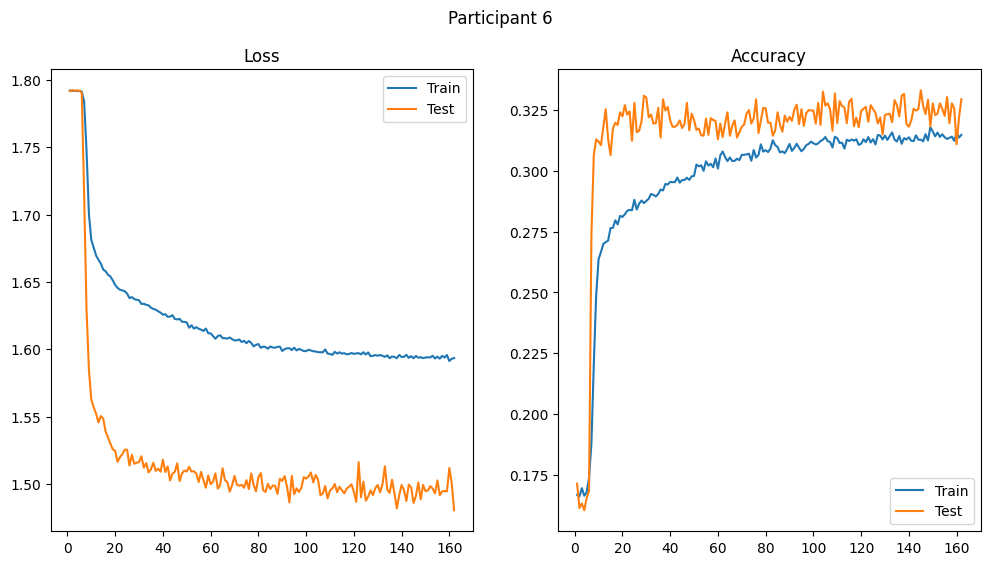

Outer Loop 2 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [1]



Epoch [  1/500] - Avg Training Loss: 1.7921 Train Accuracy: 0.16 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [  6/500] - Avg Training Loss: 1.6796 Train Accuracy: 0.26 - Test Loss: 1.74 - Test Accuracy: 0.23
Epoch [ 11/500] - Avg Training Loss: 1.6502 Train Accuracy: 0.28 - Test Loss: 1.73 - Test Accuracy: 0.24
Epoch [ 16/500] - Avg Training Loss: 1.6373 Train Accuracy: 0.28 - Test Loss: 1.72 - Test Accuracy: 0.24
Epoch [ 21/500] - Avg Training Loss: 1.6275 Train

<Figure size 640x480 with 0 Axes>

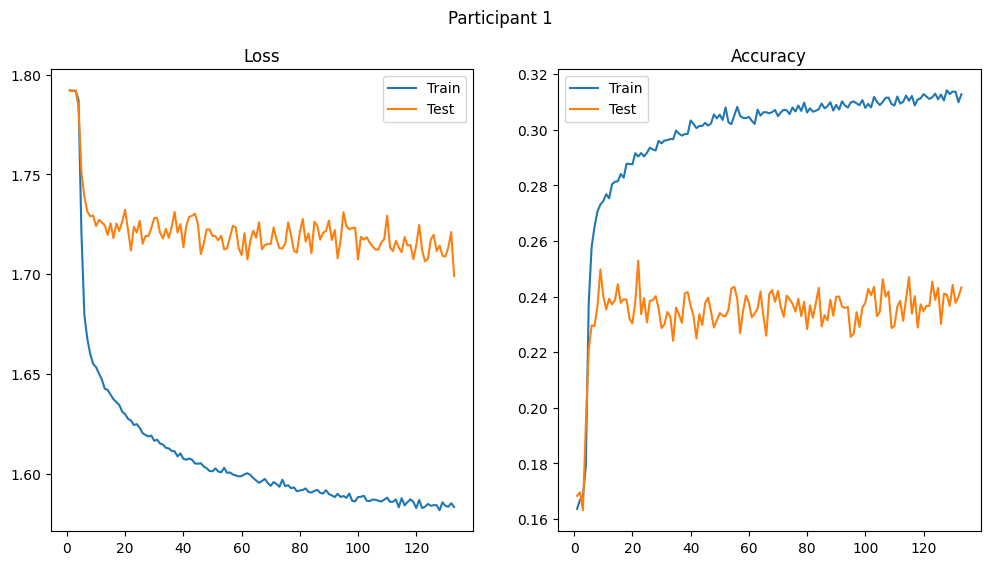

Outer Loop 3 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15]
      Test index:                                         [13]



Epoch [  1/500] - Avg Training Loss: 1.7921 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [  6/500] - Avg Training Loss: 1.7779 Train Accuracy: 0.19 - Test Loss: 1.80 - Test Accuracy: 0.18
Epoch [ 11/500] - Avg Training Loss: 1.6643 Train Accuracy: 0.27 - Test Loss: 1.78 - Test Accuracy: 0.23
Epoch [ 16/500] - Avg Training Loss: 1.6382 Train Accuracy: 0.28 - Test Loss: 1.77 - Test Accuracy: 0.25
Epoch [ 21/500] - Avg Training Loss: 1.6255 Train

<Figure size 640x480 with 0 Axes>

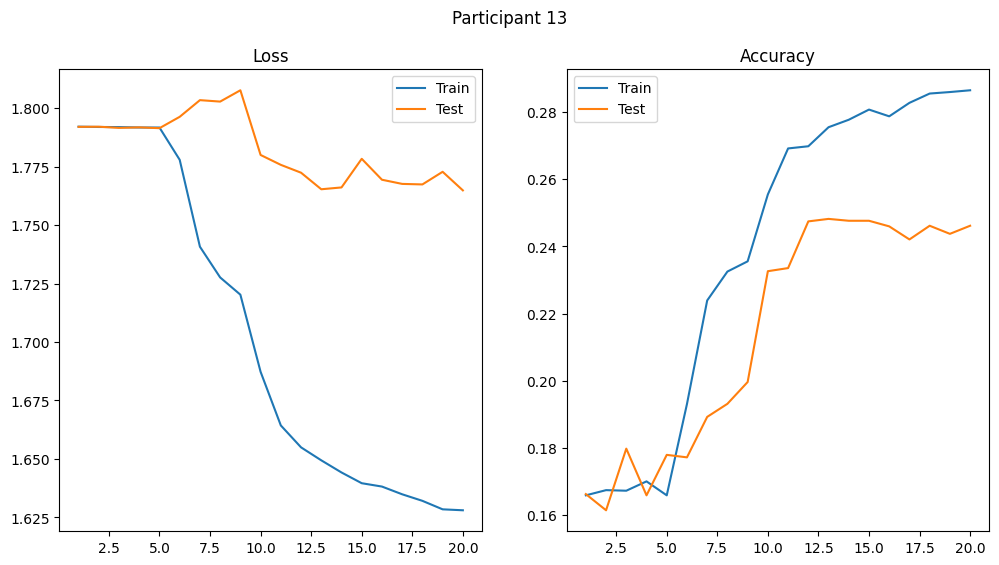

Outer Loop 4 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [7]



Epoch [  1/500] - Avg Training Loss: 1.7920 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [  6/500] - Avg Training Loss: 1.7212 Train Accuracy: 0.24 - Test Loss: 1.80 - Test Accuracy: 0.20
Epoch [ 11/500] - Avg Training Loss: 1.6427 Train Accuracy: 0.28 - Test Loss: 1.83 - Test Accuracy: 0.20
Epoch [ 16/500] - Avg Training Loss: 1.6287 Train Accuracy: 0.29 - Test Loss: 1.84 - Test Accuracy: 0.21
Epoch [ 21/500] - Avg Training Loss: 1.6213 Train

<Figure size 640x480 with 0 Axes>

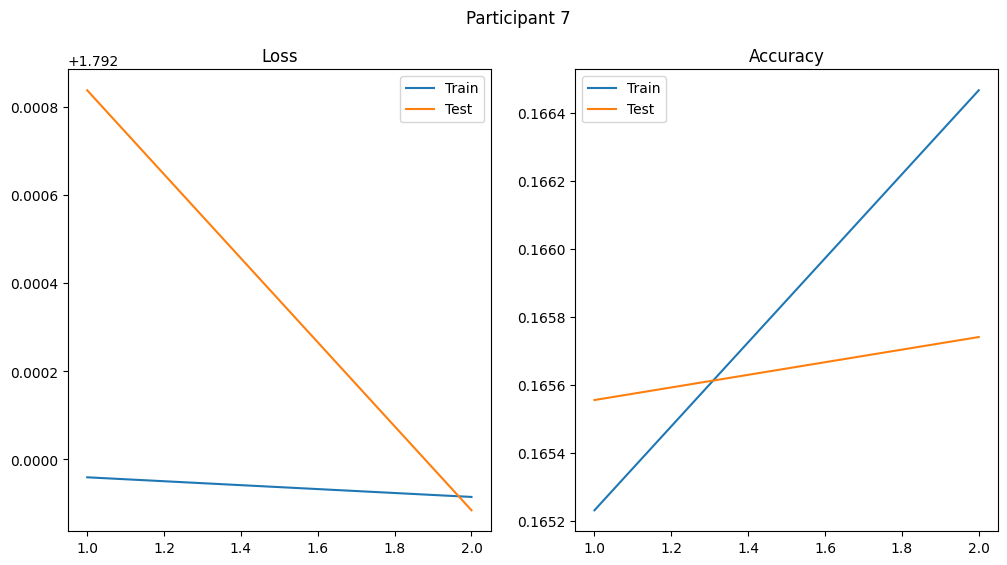

Outer Loop 5 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [5]



Epoch [  1/500] - Avg Training Loss: 1.7921 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [  6/500] - Avg Training Loss: 1.7448 Train Accuracy: 0.22 - Test Loss: 1.68 - Test Accuracy: 0.28
Epoch [ 11/500] - Avg Training Loss: 1.6827 Train Accuracy: 0.26 - Test Loss: 1.48 - Test Accuracy: 0.37
Epoch [ 16/500] - Avg Training Loss: 1.6624 Train Accuracy: 0.27 - Test Loss: 1.43 - Test Accuracy: 0.38
Epoch [ 21/500] - Avg Training Loss: 1.6515 Train

<Figure size 640x480 with 0 Axes>

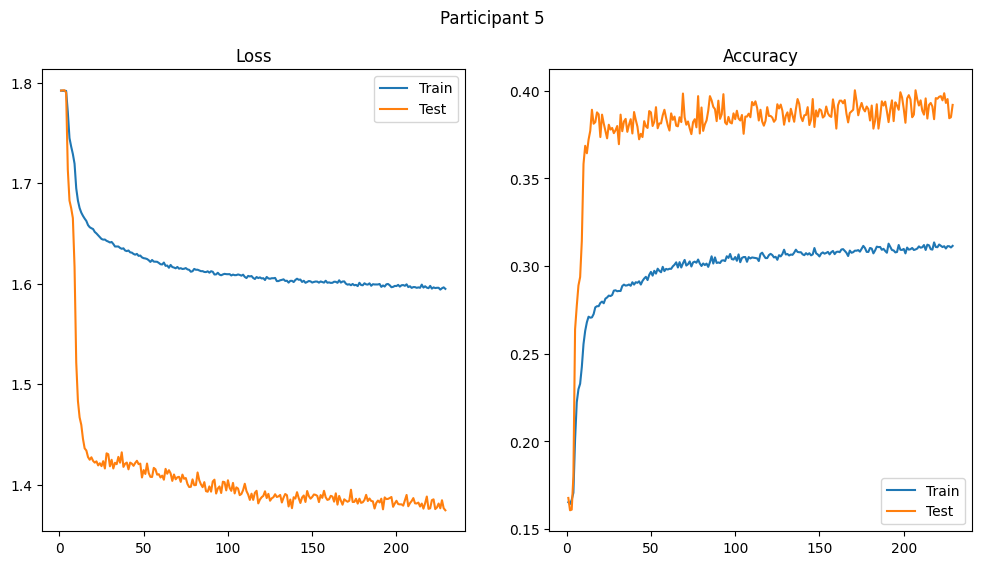

Outer Loop 6 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [3]



Epoch [  1/500] - Avg Training Loss: 1.7921 Train Accuracy: 0.16 - Test Loss: 1.79 - Test Accuracy: 0.18
Epoch [  6/500] - Avg Training Loss: 1.6902 Train Accuracy: 0.25 - Test Loss: 1.61 - Test Accuracy: 0.31
Epoch [ 11/500] - Avg Training Loss: 1.6607 Train Accuracy: 0.27 - Test Loss: 1.56 - Test Accuracy: 0.32
Epoch [ 16/500] - Avg Training Loss: 1.6489 Train Accuracy: 0.27 - Test Loss: 1.53 - Test Accuracy: 0.33
Epoch [ 21/500] - Avg Training Loss: 1.6379 Train

<Figure size 640x480 with 0 Axes>

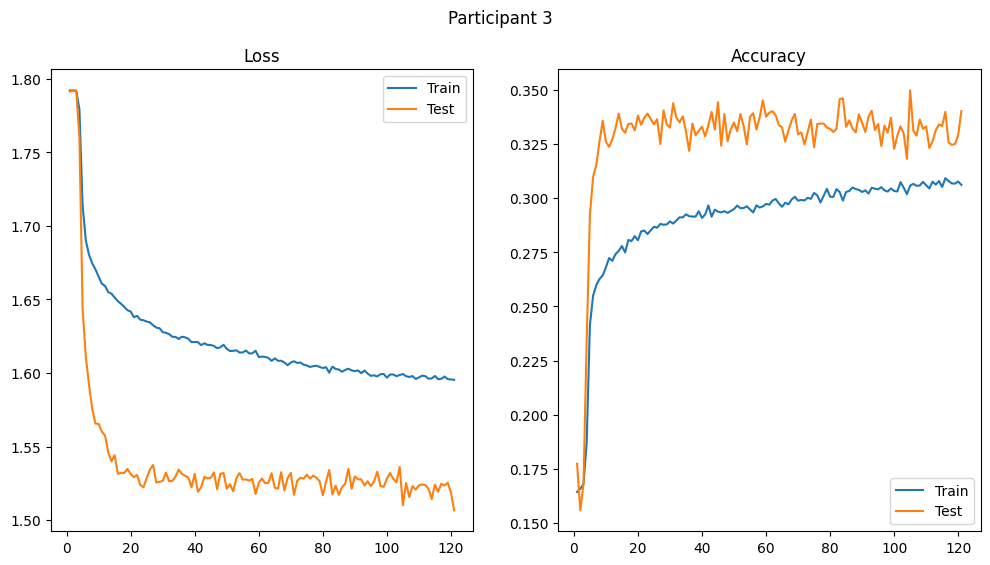

Outer Loop 7 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15]
      Test index:                                         [12]



Epoch [  1/500] - Avg Training Loss: 1.7920 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.16
Epoch [  6/500] - Avg Training Loss: 1.7913 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [ 11/500] - Avg Training Loss: 1.6707 Train Accuracy: 0.26 - Test Loss: 1.61 - Test Accuracy: 0.31
Epoch [ 16/500] - Avg Training Loss: 1.6518 Train Accuracy: 0.27 - Test Loss: 1.61 - Test Accuracy: 0.31
Epoch [ 21/500] - Avg Training Loss: 1.6401 Train

<Figure size 640x480 with 0 Axes>

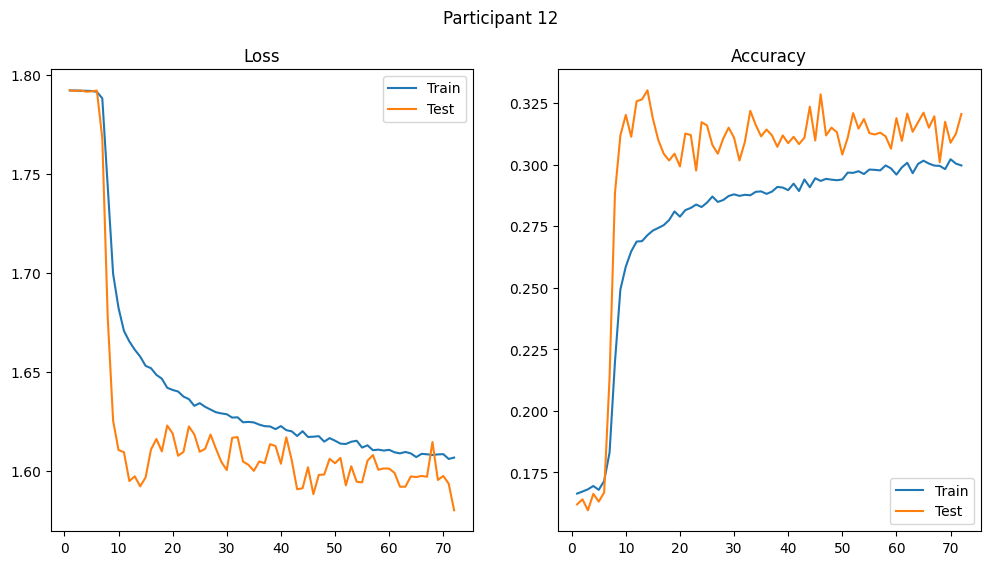

Outer Loop 8 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15]
      Test index:                                         [10]



Epoch [  1/500] - Avg Training Loss: 1.7920 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.16
Epoch [  6/500] - Avg Training Loss: 1.7401 Train Accuracy: 0.23 - Test Loss: 1.72 - Test Accuracy: 0.24
Epoch [ 11/500] - Avg Training Loss: 1.6675 Train Accuracy: 0.27 - Test Loss: 1.65 - Test Accuracy: 0.27
Epoch [ 16/500] - Avg Training Loss: 1.6469 Train Accuracy: 0.28 - Test Loss: 1.64 - Test Accuracy: 0.27
Epoch [ 21/500] - Avg Training Loss: 1.6365 Train

<Figure size 640x480 with 0 Axes>

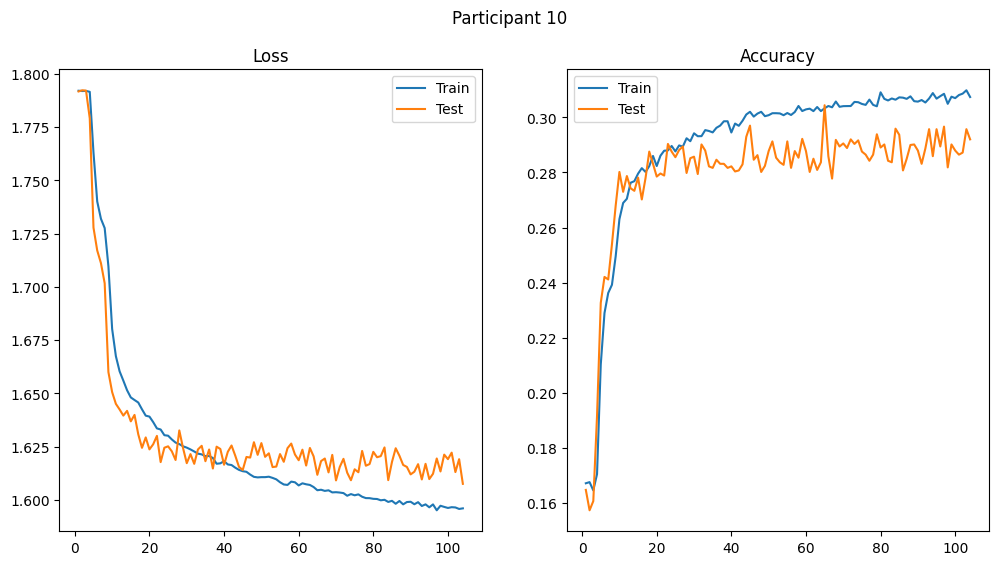

Outer Loop 9 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15]
      Test index:                                         [14]



Epoch [  1/500] - Avg Training Loss: 1.7920 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [  6/500] - Avg Training Loss: 1.7382 Train Accuracy: 0.23 - Test Loss: 1.80 - Test Accuracy: 0.18
Epoch [ 11/500] - Avg Training Loss: 1.6679 Train Accuracy: 0.26 - Test Loss: 1.83 - Test Accuracy: 0.18
Epoch [ 16/500] - Avg Training Loss: 1.6303 Train Accuracy: 0.29 - Test Loss: 1.86 - Test Accuracy: 0.18
Epoch [ 21/500] - Avg Training Loss: 1.6180 Train

<Figure size 640x480 with 0 Axes>

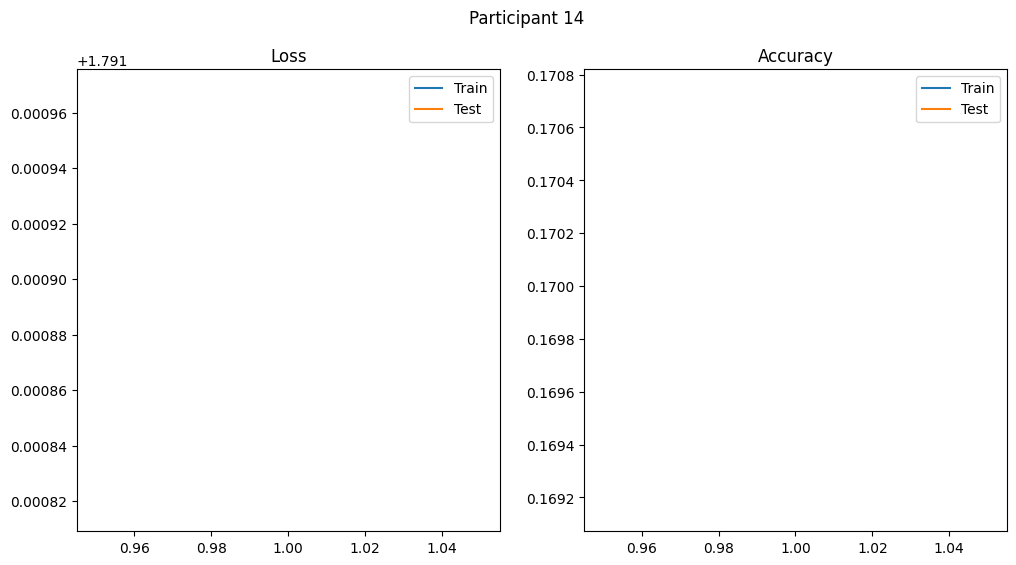

Outer Loop 10 

      Train epochs' shape:                                (64800, 64, 100)
      Test epochs' shape:                                 (5400, 64, 100)
      Test labels' shape:                                 (5400, 6)
      Train labels' shape (without encoding):             (64800,)
      Test labels' shape (without encoding):              (5400,)
      Train index:                                        [1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [4]



Epoch [  1/500] - Avg Training Loss: 1.7921 Train Accuracy: 0.17 - Test Loss: 1.79 - Test Accuracy: 0.17
Epoch [  6/500] - Avg Training Loss: 1.7486 Train Accuracy: 0.22 - Test Loss: 1.78 - Test Accuracy: 0.20
Epoch [ 11/500] - Avg Training Loss: 1.6431 Train Accuracy: 0.28 - Test Loss: 1.81 - Test Accuracy: 0.23
Epoch [ 16/500] - Avg Training Loss: 1.6280 Train Accuracy: 0.29 - Test Loss: 1.82 - Test Accuracy: 0.22
Epoch [ 21/500] - Avg Training Loss: 1.6191 Trai

In [ ]:
participants = [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
class_numbers=4
num_subjects = len(EEG_epochs_aug)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.001
weight_decay=0.1*learning_rate


kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(EEG_epochs_aug)):
    
    
    
    train_epochs = np.concatenate([EEG_epochs_aug[j] for j in train_index])
    test_epochs = np.concatenate([EEG_epochs_aug[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    
    model = EEGNetv4(in_chans=64, n_classes=6, input_window_samples=100)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    model.to(device)
    model.train()
    
    patience = 50
    best_metric = float('inf')
    counter = 1
    best_model_state = model.state_dict()
    
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    models = []
    for epoch in range(max_epochs):
        
        train_running_loss = 0
        y_true_temp = []
        y_pred_temp = []
        
        
        batch_size = 12
        fold_num = int(EEG_epochs_aug[i].shape[0] // batch_size)
        stratified_kfold = StratifiedKFold(n_splits=fold_num, random_state=10, shuffle=True)
        
        for _, (_, train_batch_index) in enumerate(stratified_kfold.split(train_epochs, no_encoded_train_labels)):
        
            batch_epoch, batch_label = train_epochs[train_batch_index], train_labels[train_batch_index]
            batch_epoch, batch_label = torch.tensor(batch_epoch, dtype=torch.float32).to(device), torch.tensor(batch_label, dtype=torch.float32).to(device)
            optimizer.zero_grad()
            train_outputs = model(batch_epoch)
            loss = criterion(train_outputs, batch_label)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            y_pred_train = torch.argmax(train_outputs, 1).tolist()
            y_true_train = torch.argmax(batch_label, 1).tolist()
            y_true_temp.extend(y_true_train)
            y_pred_temp.extend(y_pred_train)
        
        test_dataset = EEG_Dataset(test_epochs, test_labels, transform=None)
        test_loader = DataLoader(test_dataset, batch_size=test_epochs.shape[0])
        
        with torch.no_grad():
            for test_input_epoch, test_label_test in test_loader:
                
                test_input_epoch, test_label_test = test_input_epoch.to(torch.float32).to(device), test_label_test.to(torch.float32).to(device)
                test_output = model(test_input_epoch)

                test_loss = criterion(test_output, test_label_test).item()
                y_pred_test = torch.argmax(test_output, 1).tolist()
                y_true_test = torch.argmax(test_label_test, 1).tolist()
                conf_mat = confusion_matrix(y_true_test, y_pred_test)
                test_accuracy = np.trace(conf_mat) / conf_mat.sum()
    
        train_conf_mat = confusion_matrix(y_true_temp, y_pred_temp)
        train_accuracy = np.trace(train_conf_mat) / train_conf_mat.sum()
        avg_train_loss = train_running_loss / fold_num
        
        train_loss_epochs.append(avg_train_loss)
        train_acc_epochs.append(train_accuracy)
        test_loss_epochs.append(test_loss)
        test_acc_epochs.append(test_accuracy)
        
        if epoch % 5 == 0:
            print(f"Epoch [{(epoch + 1): 3d}/{max_epochs}] - Avg Training Loss: {avg_train_loss:.4f} Train Accuracy: {train_accuracy:.2f} - Test Loss: {test_loss:.2f} - Test Accuracy: {test_accuracy:.2f}")
        
        if test_loss < best_metric:
            best_metric = test_loss
            best_model_state = model.state_dict()
            counter = 1
        else:
            counter += 1
        
        if counter > patience:
            break
        best_epoch = epoch-patience+2
        epochs_range = np.arange(1, len(train_loss_epochs[:best_epoch])+1)
        
        
        
        
    model.load_state_dict(best_model_state)
    models.append(best_model_state)
    with torch.no_grad():
        for test_input_epoch, test_label_test in test_loader:
                
            test_input_epoch, test_label_test = test_input_epoch.to(torch.float32).to(device), test_label_test.to(torch.float32).to(device)
            test_output = model(test_input_epoch)
            test_loss = criterion(test_output, test_label_test).item()
            y_pred_test = torch.argmax(test_output, 1).tolist()
            y_true_test = torch.argmax(test_label_test, 1).tolist()
            all_tests_true.append(y_true_test)
            all_tests_pred.append(y_pred_test)
            conf_mat = confusion_matrix(y_true_test, y_pred_test)
            test_accuracy = np.trace(conf_mat) / conf_mat.sum()
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:best_epoch])
    plt.plot(epochs_range, test_loss_epochs[:best_epoch])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:best_epoch])
    plt.plot(epochs_range, test_acc_epochs[:best_epoch])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [32]:
len(all_tests_pred[2])

240

In [16]:
confusion_matrices = []
for i in range(len(all_tests_pred)):
    y_true = all_tests_true[i]
    y_pred = all_tests_pred[i]
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [17]:
summation = pd.DataFrame(sum(confusion_matrices), index=['L (True)', 'LS (True)', 'S (True)', 'RS (True)', 'R (True)', 'Rest (True)'], columns=['L (Pred)', 'LS (Pred)', 'S (Pred)', 'RS (True)', 'R (True)', 'Rest (Pred)'])
summation

,L (Pred),LS (Pred),S (Pred),RS (True),R (True),Rest (Pred)
L (True),284,74,96,177,69,80
LS (True),75,285,79,75,214,52
S (True),82,90,257,69,84,198
RS (True),261,81,75,214,80,69
R (True),87,261,81,98,199,54
Rest (True),95,83,234,79,84,205


In [18]:
summation.sum(axis=1)

L (True)       780
LS (True)      780
S (True)       780
RS (True)      780
R (True)       780
Rest (True)    780
dtype: int64

In [19]:
summation / 780 * 100

,L (Pred),LS (Pred),S (Pred),RS (True),R (True),Rest (Pred)
L (True),36.410256,9.487179,12.307692,22.692308,8.846154,10.256410
LS (True),9.615385,36.538462,10.128205,9.615385,27.435897,6.666667
S (True),10.512821,11.538462,32.948718,8.846154,10.769231,25.384615
RS (True),33.461538,10.384615,9.615385,27.435897,10.256410,8.846154
R (True),11.153846,33.461538,10.384615,12.564103,25.512821,6.923077
Rest (True),12.179487,10.641026,30.000000,10.128205,10.769231,26.282051


In [ ]:
import pickle
with open("3class_all_tests_pred", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("3class_all_tests_true", "wb") as fp:
    pickle.dump(all_tests_true, fp)

    
print(all_tests_pred[1][1].shape)
print(all_tests_pred[12][1].shape)

In [ ]:
with open("3class_all_tests_pred", "rb") as fp:
    rand_var = pickle.load(fp)

    
with open("3class_all_tests_true", "rb") as fp:
    rand_var2 = pickle.load(fp)
print(rand_var[12][1].shape)
print(rand_var2[12][1].shape)

In [ ]:
all_tests_pred[1][2].shape

In [ ]:
np.argmax(all_tests_true[12][1], axis=1)+1

In [ ]:
a = np.array([[1, 2, 3], [4, 50, 6]])
np.sum(a, axis=1)

In [ ]:
y_true

In [ ]:
confusion_matrices_ap = []
y_pred_prob = []
for i in range(len(all_tests_pred)):
    y_pred = np.zeros(all_tests_true[i][0].shape)
    for j in range(len(all_tests_pred[1])):
        y_pred += all_tests_pred[i][j]
    y_pred_prob.append(y_pred/6)
    confusion_matrices_ap.append(confusion_matrix(np.argmax(all_tests_true[i][0], axis=1)+1, np.argmax(y_pred_prob[i], axis=1)+1))

In [ ]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)', 'class 3 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)', 'class 3 (Pred)'])
summation

In [ ]:
total_samples = summation.values.sum()
correct_predictions = summation.values.trace()
overall_accuracy = correct_predictions / total_samples

# Calculate accuracy for each class
class_accuracy = summation.values.diagonal() / summation.sum(axis=1)

# Print results
print(f"Overall Accuracy: {overall_accuracy:.2%}")

for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for Class {i + 1}: {acc:.2%}")

In [ ]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


In [ ]:
summation / (13 * 40) * 100

In [ ]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])

# Test for the effect of calibration:

In [32]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [49]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [50]:
"{:02}{:02}".format(2, 3)

'0203'

In [51]:
models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [52]:
Calibrated_models["1406"].summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 36)                20772     
                                                                 
 dense_252 (Dense)           (None, 4)                 148       
                                                                 
 dense_253 (Dense)           (None, 2)                 10        
                                                                 
Total params: 20,930
Trainable params: 20,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


Outer Loop 1 and Inner Loop 1: 

      Train epochs' shape:                                (1337, 64, 1123)
      Cross-validation epochs' shape:                     (420, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [1, 2, 3, 4, 5, 6, 7, 8, 10, 13]
      Cross-validation index:                            [0, 9, 12]
      Test index:                                        [11]



Train features shape:             (1337, 576)
Cross-validation features shape:  (420, 576)
Test features shape:              (140, 576)
Outer Loop 1 and Inner Loop 2: 

      Train epochs' shape:                                (1477, 64, 1123)
      Cross-validation epochs' shape:                     (280, 64, 1123)
      Test epochs' shape:                                 (140, 64, 1123)
      Train index:                                       [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13]
      Cross-validation index:      

In [26]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [27]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [28]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

,class 1 (Pred),class 2 (Pred)
class 1 (True),358,162
class 2 (True),202,315


In [31]:
summation / 520

,class 1 (Pred),class 2 (Pred)
class 1 (True),0.688462,0.311538
class 2 (True),0.388462,0.605769


In [29]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")


Average metrics for binary classification (Left vs Right hand):


       Accuracy:                  0.65

       Precision:                 0.66

       Recall (Sensitivity):      0.61     

       F1 Score:                  0.63

